
# **0. Mask augmentation**

*   mount google drive
*   MaskTheFace github (https://github.com/aqeelanwar/MaskTheFace.git)
*   include mask augmented face image samples in report



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd '/content/drive/MyDrive/detect_mask'

In [ ]:
!unzip data.zip

In [ ]:
! git clone https://github.com/aqeelanwar/MaskTheFace.git

In [59]:
! pip3 install cmake
! pip3 install dlib
! pip3 install scikit-learn
! pip3 install wandb
! pip3 install face-recognition
! pip3 install face-recognition-models
! pip3 install dotmap
! pip3 install torch
! pip3 install torchvision
! pip3 install opencv-python
! pip3 install chardet

   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.4 MB 660.6 kB/s eta 0:00:25
   ---------------------------------------- 0.1/16.4 MB 1.1 MB/s eta 0:00:16
   -- ------------------------------------- 1.0/16.4 MB 7.7 MB/s eta 0:00:03
   ----- ---------------------------------- 2.1/16.4 MB 12.4 MB/s eta 0:00:02
   -------- ------------------------------- 3.3/16.4 MB 14.0 MB/s eta 0:00:01
   ---------- ----------------------------- 4.5/16.4 MB 16.8 MB/s eta 0:00:01
   ------------- -------------------------- 5.7/16.4 MB 17.2 MB/s eta 0:00:01
   ---------------- ----------------------- 6.8/16.4 MB 18.1 MB/s eta 0:00:01
   ------------------- -------------------- 8.0/16.4 MB 19.6 MB/s eta 0:00:01
   ---------------------- ----------------- 9.1/16.4 MB 19.5 MB/s eta 0:00:01
   ------------------------ --------------- 10.1/16.4 MB 19.5 MB/s eta 0:00:01
  

In [ ]:
cd 'MaskTheFace'

In [ ]:
# print current directory
import os
os.getcwd()
!pip list

In [ ]:
! python mask_the_face.py --path "/content/drive/MyDrive/detect_mask/train/not_wearing_mask" --mask_type "random"

In [ ]:
! python mask_the_face.py --path "/content/drive/MyDrive/detect_mask/val/not_wearing_mask" --mask_type "random"

In [ ]:
import wandb
wandb.login()
#key: d9035e8bd0139db174a8c8ecd86c3df7e33e865b

# **1. Prepare Data for Training**

*   data_loader using *torchvision.datasets.ImageFolder* for Custom dataset
*   **image augmentation** in *transforms*
*   include augmented face image samples in report



In [1]:
# import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
# transforms for image augmentation
train_transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(size=(112, 112)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-45, 45))
])

val_transform = torchvision.transforms.Compose([

    transforms.ToTensor(),
    transforms.Resize(size=(112, 112))
])

In [3]:
train_path = r"C:\Users\phyou\Documents\AI\train"
val_path = r"C:\Users\phyou\Documents\AI\val"
from torchvision.datasets import ImageFolder

# write ImageFolder code below
train_data = ImageFolder(root=train_path, transform=train_transform)
valid_data = ImageFolder(root=val_path, transform=val_transform)

# check the label
# train_data.class_to_idx
print("Train data labels:", train_data.class_to_idx)
# val_data.class_to_idx
print("Validation data labels:", valid_data.class_to_idx)

Train data labels: {'not_wearing_mask': 0, 'wearing_mask': 1}
Validation data labels: {'not_wearing_mask': 0, 'wearing_mask': 1}


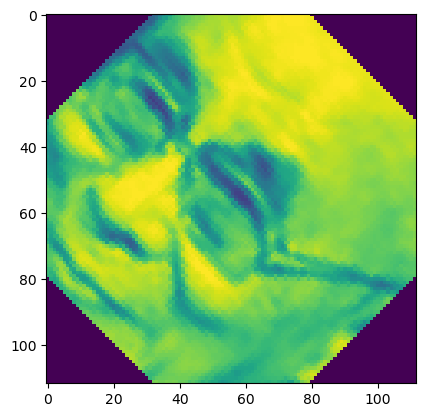

In [4]:
dataiter = iter(train_data)
images, labels = next(dataiter)
image = images[0]
plt.imshow(image)
plt.show()

# **2. Prepare Model**

*   Pytorch ResNet - *ref*. https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
*   use **ResNet50** from torchvision.model_zoo
*   explore more models in https://pytorch.org/vision/stable/models.html
*   **change the dimension of the classifier**

In [5]:
# assign device cpu or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# import packages for importing models
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights


In [13]:
# load model and change the # of classes
num_classes = 1 #마스크 유무 0 or 1
pretrained = False
model = models.resnet50(pretrained= pretrained)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

c:\Users\phyou\anaconda3\envs\myvenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\phyou\anaconda3\envs\myvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# **3. Training**


*   write **training code** including belows:
   - hyper parameters such as batch size, learning rate, epoch
   - criterion(loss function such as BCELoss), optimizer(eg. Adam, SGD, etc.)  and scheduler
   - save model weight

*   **print training/validation loss and accuracy** per epoch or iteration
*   inlcude visualizer, **tensorboard**, to show training/validation accuracy and loss


In [8]:
import torch
import wandb
import sklearn
from sklearn import metrics
import datetime
import os
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
wandb.login()
# use wandb.init

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: y60631188 (phur99). Use `wandb login --relogin` to force relogin


True

In [9]:
def train_model(dataloader, model, loss_fn, optimizer):
  # write training code
  model.train()
  running_loss = 0
  acc_temp = 0

  for inputs, labels in tqdm(dataloader):
    inputs, labels = inputs.to(device), labels.to(device)

    output = model(inputs).squeeze()  
    loss = loss_fn(output, labels.float())
    
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()

    pred = torch.round(torch.sigmoid(output))
    acc_temp += pred.eq(labels).sum().item()
    running_loss += loss.item() * inputs.size(0)
    
  acc = acc_temp / len(dataloader.dataset)
  running_loss = running_loss / len(dataloader.dataset)
  
  return running_loss, acc

In [10]:
      
def val_model(dataloader, model, loss_fn):
  # write validation code
  model.eval()
  predictions = []
  true_labels = []
  
  with torch.no_grad():
    running_loss = 0
    acc_temp = 0

    for inputs, labels in tqdm(dataloader):
      inputs, labels = inputs.to(device), labels.to(device)

      output = model(inputs).squeeze()
      running_loss += loss_fn(output, labels.float()).item() * inputs.size(0)
      output = torch.sigmoid(output)
      pred = torch.round(output)

      acc_temp += pred.eq(labels).sum().item()

      predictions.append(output) 
      true_labels.append(labels)

    acc = acc_temp / len(dataloader.dataset)
    running_loss = running_loss / len(dataloader.dataset)
    predictions = torch.cat(predictions, dim=0)
    true_labels = torch.cat(true_labels, dim=0)
    return running_loss, acc, true_labels, predictions

In [ ]:
# training and validation code can be writed in one function. It's your taste!



In [14]:
# hyper parameters
num_epochs = 50
batch_size = 64
learning_rate = 0.01
weight_decay = 0
# data_loader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
vaild_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers= 4)
# optimizer, loss, scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


In [15]:
save_path = r"C:\Users\phyou\Documents\AI\Result\\" +  datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
os.makedirs(save_path, exist_ok=True)
os.chdir(save_path)    
project = 'mask_detection'
name = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

min_loss = np.inf
wandb.init(project = f"{project}", name=f"{name}", config = {
    "model" : model.__class__.__name__,
    "epochs": num_epochs,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "weight_decay" : weight_decay,
    "pretrained" : pretrained
}, reinit=True)

for epoch in range(num_epochs):
    t_loss, t_acc = train_model(dataloader=train_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer)
    v_loss, v_acc, true_labels, predictions = val_model(dataloader=vaild_dataloader, model=model, loss_fn=loss_fn)
    if v_acc < 0.6 : break
    
    if v_loss < min_loss :
        print(f"[INFO] v_loss has been improved from {min_loss:.5f} to {v_loss:.5f}. Saving Model...")
        min_loss = v_loss
        torch.save(model.state_dict(), f'{model.__class__.__name__}_{min_loss:.5f}.pth')

    print(  f'epoch = {epoch + 1:02d}, train_loss : {t_loss:.5f}, '
            f'vaild_loss : {v_loss:.5f}, '
            f'train_acc : {t_acc:.5f}, '
            f'vaild_acc : {v_acc:.5f}')

    fpr, tpr, thresholds = roc_curve(true_labels.cpu().numpy(), predictions.cpu().numpy())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'epoch : {epoch + 1:02d} / (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    wandb.log({
        "train_loss" : t_loss,
        "vaild_loss" : v_loss,
        "train_acc" : t_acc,
        "vaild_acc" : v_acc, 
        'ROC Curve': wandb.Image(plt)}
    )
    plt.close()        

   

train_acc,▁▃▄▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
vaild_acc,▄▄▅▇██▇▆▇▇▄▇▆▇▆█▅▆▇█▇▃▇▇▅▇█▆▇█▇▁▇▂███▆▅▇
vaild_loss,▃▆▄▁▁▁▁▂▂▂▃▂▂▂▂▁▃▂▂▁▁▄▂▂▄▂▁▂▂▁▂█▂▆▁▁▁▄▃▂
train_acc,0.95513
train_loss,0.113
vaild_acc,0.98005
vaild_loss,0.07797


100%|██████████| 62/62 [00:15<00:00,  4.01it/s]


[INFO] v_loss has been improved from inf to 0.28827. Saving Model...
epoch = 01, train_loss : 0.41254, vaild_loss : 0.28827, train_acc : 0.85288, vaild_acc : 0.93182


100%|██████████| 62/62 [00:14<00:00,  4.15it/s]


[INFO] v_loss has been improved from 0.28827 to 0.26875. Saving Model...
epoch = 02, train_loss : 0.28858, vaild_loss : 0.26875, train_acc : 0.89178, vaild_acc : 0.90505


100%|██████████| 62/62 [00:14<00:00,  4.19it/s]


[INFO] v_loss has been improved from 0.26875 to 0.12882. Saving Model...
epoch = 03, train_loss : 0.24072, vaild_loss : 0.12882, train_acc : 0.90237, vaild_acc : 0.95480


100%|██████████| 62/62 [00:14<00:00,  4.29it/s]


epoch = 04, train_loss : 0.21542, vaild_loss : 0.28716, train_acc : 0.91203, vaild_acc : 0.92146


100%|██████████| 62/62 [00:14<00:00,  4.31it/s]


epoch = 05, train_loss : 0.19227, vaild_loss : 0.14376, train_acc : 0.92153, vaild_acc : 0.96414


100%|██████████| 62/62 [00:14<00:00,  4.23it/s]


[INFO] v_loss has been improved from 0.12882 to 0.08065. Saving Model...
epoch = 06, train_loss : 0.17485, vaild_loss : 0.08065, train_acc : 0.93102, vaild_acc : 0.97449


100%|██████████| 62/62 [00:14<00:00,  4.30it/s]


[INFO] v_loss has been improved from 0.08065 to 0.03711. Saving Model...
epoch = 07, train_loss : 0.16155, vaild_loss : 0.03711, train_acc : 0.93186, vaild_acc : 0.98838


100%|██████████| 62/62 [00:14<00:00,  4.25it/s]


epoch = 08, train_loss : 0.15124, vaild_loss : 0.04265, train_acc : 0.93404, vaild_acc : 0.98712


100%|██████████| 62/62 [00:15<00:00,  4.11it/s]


epoch = 09, train_loss : 0.14091, vaild_loss : 0.05750, train_acc : 0.94035, vaild_acc : 0.98409


100%|██████████| 62/62 [00:14<00:00,  4.29it/s]


epoch = 10, train_loss : 0.14293, vaild_loss : 0.24757, train_acc : 0.94026, vaild_acc : 0.94773


100%|██████████| 62/62 [00:14<00:00,  4.29it/s]


epoch = 11, train_loss : 0.13836, vaild_loss : 0.06491, train_acc : 0.94488, vaild_acc : 0.97727


100%|██████████| 62/62 [00:14<00:00,  4.26it/s]


epoch = 12, train_loss : 0.12978, vaild_loss : 0.09937, train_acc : 0.94682, vaild_acc : 0.97222


100%|██████████| 62/62 [00:14<00:00,  4.22it/s]


epoch = 13, train_loss : 0.12780, vaild_loss : 0.18277, train_acc : 0.94572, vaild_acc : 0.94596


100%|██████████| 62/62 [00:14<00:00,  4.28it/s]


epoch = 14, train_loss : 0.12139, vaild_loss : 0.05713, train_acc : 0.94766, vaild_acc : 0.98106


100%|██████████| 62/62 [00:14<00:00,  4.14it/s]


epoch = 15, train_loss : 0.12189, vaild_loss : 0.07086, train_acc : 0.94992, vaild_acc : 0.97020


100%|██████████| 62/62 [00:15<00:00,  3.93it/s]


epoch = 16, train_loss : 0.12214, vaild_loss : 0.09190, train_acc : 0.95085, vaild_acc : 0.96692


100%|██████████| 62/62 [00:15<00:00,  4.09it/s]


epoch = 17, train_loss : 0.11485, vaild_loss : 0.04653, train_acc : 0.95278, vaild_acc : 0.99015


100%|██████████| 62/62 [00:15<00:00,  4.06it/s]


epoch = 18, train_loss : 0.11341, vaild_loss : 0.06784, train_acc : 0.95354, vaild_acc : 0.97551


100%|██████████| 62/62 [00:15<00:00,  4.03it/s]


epoch = 19, train_loss : 0.11478, vaild_loss : 0.35853, train_acc : 0.95034, vaild_acc : 0.84621


100%|██████████| 62/62 [00:15<00:00,  4.10it/s]


[INFO] v_loss has been improved from 0.03711 to 0.03103. Saving Model...
epoch = 20, train_loss : 0.11123, vaild_loss : 0.03103, train_acc : 0.95329, vaild_acc : 0.99066


100%|██████████| 62/62 [00:15<00:00,  4.13it/s]


epoch = 21, train_loss : 0.11547, vaild_loss : 0.18234, train_acc : 0.95278, vaild_acc : 0.93813


100%|██████████| 62/62 [00:15<00:00,  3.99it/s]


epoch = 22, train_loss : 0.11450, vaild_loss : 0.05298, train_acc : 0.95228, vaild_acc : 0.98384


100%|██████████| 62/62 [00:15<00:00,  4.10it/s]


epoch = 23, train_loss : 0.10942, vaild_loss : 0.03611, train_acc : 0.95345, vaild_acc : 0.98864


100%|██████████| 62/62 [00:15<00:00,  4.08it/s]


epoch = 24, train_loss : 0.10070, vaild_loss : 0.05640, train_acc : 0.95866, vaild_acc : 0.98258


100%|██████████| 62/62 [00:15<00:00,  4.09it/s]


epoch = 25, train_loss : 0.10088, vaild_loss : 0.05714, train_acc : 0.95723, vaild_acc : 0.98308


100%|██████████| 62/62 [00:15<00:00,  4.07it/s]


epoch = 26, train_loss : 0.09711, vaild_loss : 0.03145, train_acc : 0.95883, vaild_acc : 0.99217


100%|██████████| 62/62 [00:15<00:00,  4.08it/s]


epoch = 27, train_loss : 0.10537, vaild_loss : 0.03301, train_acc : 0.95690, vaild_acc : 0.98990


100%|██████████| 62/62 [00:15<00:00,  4.09it/s]


[INFO] v_loss has been improved from 0.03103 to 0.02135. Saving Model...
epoch = 28, train_loss : 0.09764, vaild_loss : 0.02135, train_acc : 0.95917, vaild_acc : 0.99268


100%|██████████| 62/62 [00:15<00:00,  4.10it/s]


[INFO] v_loss has been improved from 0.02135 to 0.01799. Saving Model...
epoch = 29, train_loss : 0.09262, vaild_loss : 0.01799, train_acc : 0.96127, vaild_acc : 0.99444


100%|██████████| 62/62 [00:15<00:00,  4.02it/s]


epoch = 30, train_loss : 0.09401, vaild_loss : 0.02336, train_acc : 0.96034, vaild_acc : 0.99192


100%|██████████| 62/62 [00:14<00:00,  4.14it/s]


epoch = 31, train_loss : 0.09208, vaild_loss : 0.03183, train_acc : 0.96219, vaild_acc : 0.98914


100%|██████████| 62/62 [00:15<00:00,  4.09it/s]


epoch = 32, train_loss : 0.09422, vaild_loss : 0.03037, train_acc : 0.95891, vaild_acc : 0.98914


100%|██████████| 62/62 [00:15<00:00,  4.09it/s]


epoch = 33, train_loss : 0.09522, vaild_loss : 0.01977, train_acc : 0.96001, vaild_acc : 0.99192


100%|██████████| 62/62 [00:15<00:00,  4.13it/s]


epoch = 34, train_loss : 0.08846, vaild_loss : 0.20493, train_acc : 0.96286, vaild_acc : 0.95631


100%|██████████| 62/62 [00:14<00:00,  4.16it/s]


epoch = 35, train_loss : 0.09313, vaild_loss : 0.02465, train_acc : 0.95975, vaild_acc : 0.99167


100%|██████████| 62/62 [00:15<00:00,  4.12it/s]


epoch = 36, train_loss : 0.09128, vaild_loss : 0.03455, train_acc : 0.96085, vaild_acc : 0.98763


100%|██████████| 62/62 [00:15<00:00,  4.07it/s]


epoch = 37, train_loss : 0.09247, vaild_loss : 0.03364, train_acc : 0.96118, vaild_acc : 0.99066


100%|██████████| 62/62 [00:15<00:00,  4.11it/s]


epoch = 38, train_loss : 0.09350, vaild_loss : 0.12481, train_acc : 0.95891, vaild_acc : 0.97525


100%|██████████| 62/62 [00:15<00:00,  4.11it/s]


epoch = 39, train_loss : 0.08689, vaild_loss : 0.03757, train_acc : 0.96404, vaild_acc : 0.98889


100%|██████████| 62/62 [00:15<00:00,  4.10it/s]


epoch = 40, train_loss : 0.09025, vaild_loss : 0.02597, train_acc : 0.96202, vaild_acc : 0.99116


100%|██████████| 62/62 [00:15<00:00,  4.11it/s]


epoch = 41, train_loss : 0.08614, vaild_loss : 0.04700, train_acc : 0.96152, vaild_acc : 0.98258


100%|██████████| 62/62 [00:15<00:00,  3.97it/s]


epoch = 42, train_loss : 0.08827, vaild_loss : 0.05390, train_acc : 0.96085, vaild_acc : 0.98308


100%|██████████| 62/62 [00:15<00:00,  4.13it/s]


epoch = 43, train_loss : 0.08431, vaild_loss : 0.05669, train_acc : 0.96471, vaild_acc : 0.98081


100%|██████████| 62/62 [00:15<00:00,  4.13it/s]


epoch = 44, train_loss : 0.08075, vaild_loss : 0.02987, train_acc : 0.96555, vaild_acc : 0.99369


100%|██████████| 62/62 [00:15<00:00,  4.08it/s]


epoch = 45, train_loss : 0.08325, vaild_loss : 0.02239, train_acc : 0.96295, vaild_acc : 0.99444


100%|██████████| 62/62 [00:15<00:00,  4.04it/s]


epoch = 46, train_loss : 0.08565, vaild_loss : 0.03400, train_acc : 0.96202, vaild_acc : 0.98864


100%|██████████| 62/62 [00:15<00:00,  4.08it/s]


epoch = 47, train_loss : 0.08013, vaild_loss : 0.03170, train_acc : 0.96421, vaild_acc : 0.99015


100%|██████████| 62/62 [00:14<00:00,  4.15it/s]


[INFO] v_loss has been improved from 0.01799 to 0.01408. Saving Model...
epoch = 48, train_loss : 0.08311, vaild_loss : 0.01408, train_acc : 0.96236, vaild_acc : 0.99596


100%|██████████| 62/62 [00:15<00:00,  4.13it/s]


epoch = 49, train_loss : 0.08324, vaild_loss : 0.04106, train_acc : 0.96354, vaild_acc : 0.98611


100%|██████████| 62/62 [00:14<00:00,  4.16it/s]

epoch = 50, train_loss : 0.08110, vaild_loss : 0.01455, train_acc : 0.96496, vaild_acc : 0.99621
